# Federated optimization and some batch normalization strategies. 
``FedOpt`` (Reddi et al., 2020) is a generalisation of the baseline algorithm `FedAvg` (McMahan et al.). `FedOpt` rewrites the update rule of `FedAvg` and thus allows the usage of gradient descent based optimizers for the server update. More precisely, `FedAvg` update rule is the average of all the clients parameters : 

\begin{align}
    x_{t+1} = \frac{1}{|\mathcal{S}|} \sum_{i \in \mathcal{S}} x_i^t
\end{align}

With $x$ the global model's parameters ($x_i$ client $i$'s parameters)  $t$ being the current round and $\mathcal{S}$ the set of sampled clients.

This update rule can be written as : 

\begin{align} 
    x_{t+1} = x_t - \frac{1}{|\mathcal{S}|} \sum_{i \in \mathcal{S}} (x_t - x_i^t)
\end{align}

which is somewhat analogous to gradient descent based optimization methods if we added a learning rate. Recall `SGD` update rule takes the form : 
\begin{align}
    x_{t+1} = x_t - \eta \nabla f_t(x_t) 
\end{align} 

with $\eta$ being the learning rate and $f_t(x_t)$ a loss function at time step $t$. Let $\Delta_i^t = x_i^t - x_t$ represent the difference between a client and the current global model and $\Delta_t = \frac{1}{|\mathcal{S}|} \sum_{i \in \mathcal{S}} \Delta_i^t$ represent the average of the local clients differences. Considering $\Delta_t$ as pseudo gradient, we can apply `SGD` (or any gradient based optimizer) to update the global model at each rounds. 
Hence applying `SGD` with $-\Delta_t$ and $\eta = 1$ is equivalent to `FedAvg` : 

\begin{align}
    x_{t+1} & = x_t - 1 \times - \Delta_t  \\
            & = x_t + \Delta_t \\
            &= x_t + \frac{1}{|S|} \sum_{i \in S} (x_i^t - x_t)) \\
            &= \frac{1}{|S|} \sum_{i \in S} x_i^t \tag{1} 
\end{align} 

**Aggregation strategy** : instead of simply averaging the weights, one can compute a weighted average using client's local dataset sizes. 

\begin{align}
    x_{t+1} = x_t + \frac{\sum_{i \in \mathcal{S}} p_i \Delta_i^t}{\sum_{i \in \mathcal{S}} p_i} \tag{2}
\end{align}

# Imports

In [2]:
import torch 
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import datasets, transforms

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [3]:
torch.manual_seed(42)

# MNIST

One of the most significant problems in the Federated Learning field, is the heterogenous data distribution clients. For our simulation, we will use MNIST data split in a non-IID fashion, generating a 2-silo non-IID dataset where each silo contains only specific classes.

![IID vs non-IID data](figs/IID-vs-non-IID.png "IID vs non-IID data")

*from Wireless for Machine Learning: a Survey, Hellström et al. 2020*

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

def get_class_indices(dataset, class_label):
    return [i for i, (x, y) in enumerate(dataset) if y == class_label]

silo_1_classes = [0, 1, 2, 3, 4]
silo_2_classes = [5, 6, 7, 8, 9]

silo_1_indices = []
silo_2_indices = []

for cls in silo_1_classes:
    silo_1_indices.extend(get_class_indices(mnist_train, cls))

for cls in silo_2_classes:
    silo_2_indices.extend(get_class_indices(mnist_train, cls))

silo_1_data = Subset(mnist_train, silo_1_indices)
silo_2_data = Subset(mnist_train, silo_2_indices)

In [5]:
len(silo_1_data), len(silo_2_data)

(30596, 29404)

In [6]:
random_indices = np.random.choice(range(len(silo_2_data)), 10)

In [7]:
items_silo_1 = silo_1_data.__getitems__(random_indices)
items_silo_2 = silo_2_data.__getitems__(random_indices)

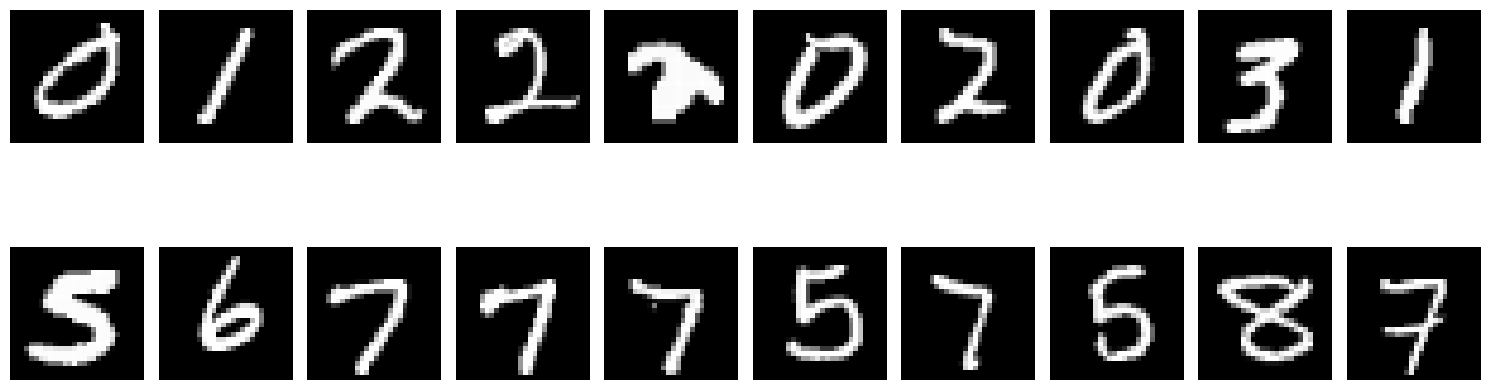

In [8]:
fig, axs = plt.subplots(2, 10, figsize=(15, 6))
for i, (image, label) in enumerate(items_silo_1):
    axs[0, i].imshow(image.squeeze(), cmap='gray') 
    axs[0, i].axis('off')  

for i, (image, label) in enumerate(items_silo_2):
    axs[1, i].imshow(image.squeeze(), cmap='gray')  
    axs[1, i].axis('off') 

plt.tight_layout()
plt.show()

# Helpers functions

In [9]:
def evaluate_model(model, test_set):
    model.eval()  
    total_loss = 0.0
    correct = 0
    total = 0

    test_loader = DataLoader(test_set, batch_size=128, shuffle=True)
    
    with torch.no_grad():  
        for inputs, labels in test_loader:
            inputs = inputs.view(inputs.size(0), -1)  
            
            outputs = model(inputs)
            
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = correct / total * 100  
    
    return accuracy

In [10]:
def exp(algo, optim, verb=True, **kwargs):
    """
        run a simulated federated learning experiment.
    """
    global_model = Net()

    client1 = Client('client1', Net(), silo_1_data)
    client2 = Client('client2', Net(), silo_2_data)
    
    clients = [client1, client2] 
    
    clientOpt = ClientOpt(epochs=kwargs['local_epochs'], lr=kwargs['client_lr'])
    serverOpt = optim(global_model, kwargs['server_lr'])
    global_model = algo(global_model, clients, clientOpt, serverOpt, kwargs['rounds'], verb=verb) 
    
    results_g = evaluate_model(global_model, mnist_test)
    results_c1 = evaluate_model(client1.model, mnist_test)
    results_c2 = evaluate_model(client2.model, mnist_test)

    return round(results_g), round(results_c1), round(results_c2)

# Model
for this task we use a basic neural network composed of a dense layer and batch norm.

In [11]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(784, 128)  
        self.bn1 = torch.nn.BatchNorm1d(128)  
        self.fc2 = torch.nn.Linear(128, 10)  
        self.relu = torch.nn.ReLU()  
        self.softmax = torch.nn.Softmax(1) 

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x) 
        x = self.relu(x) 
        x = self.fc2(x)
        x = self.softmax(x)  
        return x

# The algorithm

Below is the algorithm for FedOpt as defined in  [A Field Guide to Federated Optimization, Jianyu Wang et al. 2021](https://arxiv.org/abs/2107.06917)  which will serve as the basis for our implementation.

![FedOpt](figs/FedOptAlg.PNG "FedOpt")

In [12]:
class Client():
    """
        Client class that embeds the model and the local dataset.
    """
    def __init__(self, name, model, dataset):
        self._name = name
        self._model = model 
        self._dataset = dataset
    
    @property
    def name(self):
        return self._name

    @property
    def model(self):
        return self._model

    @property
    def dataset(self):
        return self._dataset

In [13]:
class ClientOpt():
    """
        ClientOpt class, for local optimization of the client.
    """
    def __init__(self, epochs=10, lr=0.001, batch_size=128, opt=torch.optim.SGD):
        self.epochs = epochs
        self.lr = lr
        self.batch_size = batch_size
        self.opt = opt

    def step(self, model, train, verb=True):
        model.train()  
        optimizer = self.opt(model.parameters(), lr=self.lr)
        criterion = torch.nn.CrossEntropyLoss() 

        train_loader = DataLoader(train, batch_size=128, shuffle=True)
        
        for epoch in range(self.epochs):
            running_loss = 0.0
            for inputs, labels in train_loader:
                
                inputs = inputs.view(inputs.size(0), -1)  # Flatten input
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            
            avg_loss = running_loss / len(train_loader)
            if verb:
                print(f"Epoch [{epoch+1}/{self.epochs}], Loss: {avg_loss:.4f}")

In [14]:
class ServerOpt():
    """
        Base class for server optimization. As we will see later, different optimizers can 
        be used on server side.
    """
    def __init__(self, model, lr):
        self.model = model
        self.lr = lr

    def step(self, aggregated_delta, t=None):
        pass 

In [15]:
class ServerSGD(ServerOpt):
    """
        SGD optimizer, if lr=1, it is analogous to FedAvg.
    """
    def __init__(self, model, lr=1):
        super().__init__(model, lr)
        
    def step(self, aggregated_delta, t=None):
        for param_name, delta in aggregated_delta.items():
            self.model.state_dict()[param_name].add_(self.lr * delta)

In [16]:
def FedOpt(global_model, clients, clientOpt, serverOpt, rounds, verb=True):
    # retrieving datasets length for aggregation weights.
    total_samples = sum([len(client.dataset) for client in clients])
    clients_samples = {client.name : len(client.dataset) for client in clients}
    for round in range(rounds):
        if verb:
            print(f'Round {round+1}')

        # central datastructure to store local deltas.
        clients_delta = {
            client.name : {
                name : torch.zeros_like(params,) for name, params in global_model.state_dict().items()
            } for client in clients
        } 
        
        for client in clients:
            client.model.load_state_dict(global_model.state_dict())

            clientOpt.step(client.model, client.dataset, verb=verb)
            
            # local changes
            for name in client.model.state_dict().keys():
                delta = client.model.state_dict()[name] - global_model.state_dict()[name]
                clients_delta[client.name][name] = delta
        
        aggregated_delta = {name : torch.zeros_like(params) for name, params in global_model.state_dict().items()}

        # aggregate local changes
        for client_name, local_delta in clients_delta.items():
            for param_name in local_delta.keys():
                tmp =  (local_delta[param_name] * clients_samples[client_name] / total_samples)
                tmp = tmp.to(aggregated_delta[param_name].dtype)
                aggregated_delta[param_name].add_(tmp)

        # update global model
        serverOpt.step(aggregated_delta, round+1)
    
    clients_delta.clear()
    aggregated_delta.clear()

    [client.model.load_state_dict(global_model.state_dict()) for client in clients]
        
    return global_model

In [17]:
global_acc, client1_acc, client2_acc = exp(FedOpt, ServerSGD, verb=True, local_epochs=2, rounds=10, client_lr=0.001, server_lr=1)
print(f'global acc : {global_acc}, client1 acc : {client1_acc}, client2 acc : {client2_acc}')

Round 1
Epoch [1/2], Loss: 2.2662
Epoch [2/2], Loss: 2.1749
Epoch [1/2], Loss: 2.2885
Epoch [2/2], Loss: 2.2446
Round 2
Epoch [1/2], Loss: 2.1683
Epoch [2/2], Loss: 2.0566
Epoch [1/2], Loss: 2.2515
Epoch [2/2], Loss: 2.1790
Round 3
Epoch [1/2], Loss: 2.0753
Epoch [2/2], Loss: 1.9829
Epoch [1/2], Loss: 2.1982
Epoch [2/2], Loss: 2.1096
Round 4
Epoch [1/2], Loss: 2.0126
Epoch [2/2], Loss: 1.9374
Epoch [1/2], Loss: 2.1414
Epoch [2/2], Loss: 2.0550
Round 5
Epoch [1/2], Loss: 1.9681
Epoch [2/2], Loss: 1.9000
Epoch [1/2], Loss: 2.0930
Epoch [2/2], Loss: 2.0164
Round 6
Epoch [1/2], Loss: 1.9317
Epoch [2/2], Loss: 1.8647
Epoch [1/2], Loss: 2.0550
Epoch [2/2], Loss: 1.9884
Round 7
Epoch [1/2], Loss: 1.8969
Epoch [2/2], Loss: 1.8271
Epoch [1/2], Loss: 2.0270
Epoch [2/2], Loss: 1.9683
Round 8
Epoch [1/2], Loss: 1.8579
Epoch [2/2], Loss: 1.7884
Epoch [1/2], Loss: 2.0064
Epoch [2/2], Loss: 1.9533
Round 9
Epoch [1/2], Loss: 1.8187
Epoch [2/2], Loss: 1.7548
Epoch [1/2], Loss: 1.9903
Epoch [2/2], Loss:

Results are not good, longer training and hyperparameters tuning should ameliorate the results. Also, local models are just copy of the global model, so no personalization.

# Some strategies with batch norm

When using `FedOpt` with the server learning rate set to 1 (i.e., equivalent to `FedAvg`), all model parameters, including the local statistics of batch normalization layers, are averaged. This averaging can potentially slow down generalization, as the averaged batch statistics may erase the local specificities of each silo. 

## SiloBN

SiloBN ([Siloed federated learning for multi-centric histopathology datasets, Andreux et al. 2020](https://arxiv.org/abs/2008.07424))
essentially shares the learnable parameters of batch normalization layers, while keeping the batch normalization statistics local to each client. This approach allows for somewhat personalized models that are better adapted to local datasets while still benefiting from shared general knowledge.

![SiloBN](figs/SiloBN.png "SiloBN")

In [29]:
def SiloBN(global_model, clients, clientOpt, serverOpt, rounds=50, verb=True):
    
    total_samples = sum([len(client.dataset) for client in clients])
    clients_samples = {client.name : len(client.dataset) for client in clients}

    # datastructure to keep in memory local bn statistics.
    clients_bn_stats = {
        client.name : {
            param_name : params for param_name, params in client.model.named_buffers() 
        } for client in clients
    }
    for round in range(rounds):
        if verb:
            print(f'Round {round+1}')
        
        # local deltas.
        clients_delta = {
            client.name : {
                name : torch.zeros_like(params) for name, params in global_model.named_parameters()
            } for client in clients
        } 
        
        for client in clients:
            client.model.load_state_dict(global_model.state_dict())
            if round != 0:
                for name, param in clients_bn_stats[client.name].items():
                    client.model.state_dict()[name].copy_(param)

            clientOpt.step(client.model, client.dataset, verb=verb)
           
            # save local bn stats after local update
            for name, stats in client.model.named_buffers():
                clients_bn_stats[client.name][name].copy_(stats)
            
            # compute local changes, only on learnable parameters.
            for name, _ in client.model.named_parameters():
                delta = client.model.state_dict()[name] - global_model.state_dict()[name]
                clients_delta[client.name][name].copy_(delta)

        aggregated_delta = {name : torch.zeros_like(params) for name, params in global_model.named_parameters()}

        # aggregate local changes.
        for client_name, local_delta in clients_delta.items():
            for param_name in local_delta.keys():
                tmp =  (local_delta[param_name] * clients_samples[client_name] / total_samples)
                tmp = tmp.to(aggregated_delta[param_name].dtype)
                aggregated_delta[param_name].add_(tmp)
            
        serverOpt.step(aggregated_delta, round+1)
        
    return global_model

In [30]:
_, client1_acc, client2_acc = exp(SiloBN, ServerSGD, verb=True, local_epochs=2, rounds=10, client_lr=0.001, server_lr=1)
print(f'client1 acc : {client1_acc}, client2 acc : {client2_acc}')

Round 1
Epoch [1/2], Loss: 2.2788
Epoch [2/2], Loss: 2.1978
Epoch [1/2], Loss: 2.2887
Epoch [2/2], Loss: 2.2562
Round 2
Epoch [1/2], Loss: 2.1863
Epoch [2/2], Loss: 2.0492
Epoch [1/2], Loss: 2.2661
Epoch [2/2], Loss: 2.2194
Round 3
Epoch [1/2], Loss: 2.0594
Epoch [2/2], Loss: 1.9366
Epoch [1/2], Loss: 2.2409
Epoch [2/2], Loss: 2.1789
Round 4
Epoch [1/2], Loss: 1.9665
Epoch [2/2], Loss: 1.8743
Epoch [1/2], Loss: 2.2103
Epoch [2/2], Loss: 2.1357
Round 5
Epoch [1/2], Loss: 1.9096
Epoch [2/2], Loss: 1.8354
Epoch [1/2], Loss: 2.1730
Epoch [2/2], Loss: 2.0913
Round 6
Epoch [1/2], Loss: 1.8716
Epoch [2/2], Loss: 1.8099
Epoch [1/2], Loss: 2.1312
Epoch [2/2], Loss: 2.0441
Round 7
Epoch [1/2], Loss: 1.8456
Epoch [2/2], Loss: 1.7889
Epoch [1/2], Loss: 2.0852
Epoch [2/2], Loss: 1.9949
Round 8
Epoch [1/2], Loss: 1.8263
Epoch [2/2], Loss: 1.7706
Epoch [1/2], Loss: 2.0376
Epoch [2/2], Loss: 1.9491
Round 9
Epoch [1/2], Loss: 1.8079
Epoch [2/2], Loss: 1.7528
Epoch [1/2], Loss: 1.9934
Epoch [2/2], Loss:

some struggles with client 1 and slight improvement with client 2

## FedBN
FedBN ([FedBN: Federated Learning on Non-IID Features via Local Batch Normalization, Li et al. 2021](https://arxiv.org/abs/2102.07623))is a federated learning approach where all batch normalization parameters, including the learnable parameters (e.g., scale and shift parameters) and the running statistics (e.g., mean and variance), are kept local to each client.

![FedBN](figs/FedBN.png "FedBN algorithm")

In [37]:
def FedBN(global_model, clients, clientOpt, serverOpt, rounds=50, verb=True):
    
    # datastructure to keep in memory local bn statistics.
    clients_bn_stats = {
        client.name: {
            param_name: params for param_name, params in client.model.state_dict().items() if 'bn' in param_name
        } for client in clients
    }
    
    total_samples = sum([len(client.dataset) for client in clients])
    clients_samples = {client.name : len(client.dataset) for client in clients}

    for round in range(rounds):
        if verb:
            print(f'Round {round+1}')

        # local deltas
        clients_delta = {
            client.name : {
                name : torch.zeros_like(params) for name, params in global_model.state_dict().items() if 'bn' not in name
            } for client in clients
        } 
        
        for client in clients:
            # load global model and previous round's local bn statistics.
            client.model.load_state_dict(global_model.state_dict()) 
            for param_name, param in clients_bn_stats[client.name].items():
                client.model.state_dict()[param_name].copy_(param) 

            clientOpt.step(client.model, client.dataset, verb=verb)
           
            # save local bn stats 
            for name, stats in client.model.state_dict().items():
                if 'bn' in name: 
                    clients_bn_stats[client.name][name].copy_(stats)
            
            # local changes, bn layers are excluded
            for name in client.model.state_dict().keys():
                if 'bn' not in name:
                    delta = client.model.state_dict()[name] - global_model.state_dict()[name]
                    clients_delta[client.name][name] = delta
        
        aggregated_delta = {name : torch.zeros_like(params, device='cpu') for name, params in global_model.state_dict().items() if 'bn' not in name}
        
        # aggregate local changes.
        for client_name, local_delta in clients_delta.items():
            for param_name in local_delta.keys():
                tmp =  (local_delta[param_name] * clients_samples[client_name] / total_samples)
                tmp = tmp.to(aggregated_delta[param_name].dtype)
                aggregated_delta[param_name] += tmp
            
        serverOpt.step(aggregated_delta, round+1)
    return global_model

In [38]:
_, client1_acc, client2_acc = exp(FedBN, ServerSGD, verb=True, local_epochs=2, rounds=10, client_lr=0.001, server_lr=1)
print(f'client1 acc : {client1_acc}, client2 acc : {client2_acc}')

Round 1
Epoch [1/2], Loss: 2.2596
Epoch [2/2], Loss: 2.1786
Epoch [1/2], Loss: 2.2981
Epoch [2/2], Loss: 2.2629
Round 2
Epoch [1/2], Loss: 2.1719
Epoch [2/2], Loss: 2.0571
Epoch [1/2], Loss: 2.2707
Epoch [2/2], Loss: 2.2148
Round 3
Epoch [1/2], Loss: 2.0719
Epoch [2/2], Loss: 1.9701
Epoch [1/2], Loss: 2.2324
Epoch [2/2], Loss: 2.1540
Round 4
Epoch [1/2], Loss: 1.9973
Epoch [2/2], Loss: 1.9063
Epoch [1/2], Loss: 2.1829
Epoch [2/2], Loss: 2.0964
Round 5
Epoch [1/2], Loss: 1.9390
Epoch [2/2], Loss: 1.8571
Epoch [1/2], Loss: 2.1345
Epoch [2/2], Loss: 2.0530
Round 6
Epoch [1/2], Loss: 1.8916
Epoch [2/2], Loss: 1.8133
Epoch [1/2], Loss: 2.0946
Epoch [2/2], Loss: 2.0213
Round 7
Epoch [1/2], Loss: 1.8494
Epoch [2/2], Loss: 1.7798
Epoch [1/2], Loss: 2.0633
Epoch [2/2], Loss: 1.9970
Round 8
Epoch [1/2], Loss: 1.8153
Epoch [2/2], Loss: 1.7534
Epoch [1/2], Loss: 2.0373
Epoch [2/2], Loss: 1.9770
Round 9
Epoch [1/2], Loss: 1.7875
Epoch [2/2], Loss: 1.7312
Epoch [1/2], Loss: 2.0158
Epoch [2/2], Loss:

Some improvments for client1, but still slow convergence...

# ServerOpts

As mentioned previously, `FedOpt` allows the use of gradient-descent-based optimizers on the server side. Until now, we have used approaches with the server learning rate set to 1, analogous to `FedAvg`. Due to local batch normalization statistics, server optimization with a learning rate different from 1 was complex, but with the previously discussed batch normalization strategies, we can now use optimizers on the server side!



![ServerOpts](figs/AdaptativeFed.png "Adaptative Federated Optimization")

 Here are the optimizers mentioned in Adaptative Federated Optimization, including additional bias correction for `Yogi`and `Adam`.

In [40]:
class ServerAdagrad(ServerOpt):
    def __init__(self, model, lr=0.01, beta_1=0.9, tau=0.0001):
        super().__init__(model, lr)
        self.beta_1 = beta_1
        self.tau = tau

        self.mt = {name: torch.zeros_like(param) for name, param in model.state_dict().items()}
        self.vt = {name: torch.zeros_like(param) for name, param in model.state_dict().items()}
        
    def step(self, aggregated_delta, t=None):
        for param_name, delta in aggregated_delta.items():
            self.mt[param_name] = self.beta_1 * self.mt[param_name] + (1 - self.beta_1) * delta
            self.vt[param_name] += delta**2
            
            adjusted_lr = self.lr / (torch.sqrt(self.vt[param_name]) + self.tau)
            self.model.state_dict()[param_name].add_(adjusted_lr * self.mt[param_name])

In [41]:
class ServerYogi(ServerOpt):
    def __init__(self, model, lr=0.01, beta_1=0.9, beta_2=0.99, tau=0.0001):
        super().__init__(model, lr)
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.tau = tau
        
        self.mt = {name: torch.zeros_like(param) for name, param in model.state_dict().items()}
        self.vt = {name: torch.zeros_like(param) for name, param in model.state_dict().items()}

    def step(self, aggregated_delta, t=None):
        for param_name, delta in aggregated_delta.items():
            self.mt[param_name] = self.beta_1 * self.mt[param_name] + (1 - self.beta_1) * delta
            self.vt[param_name] -= (1 - self.beta_2) * delta**2 * torch.sign(self.vt[param_name] - delta**2)

            # bias correction
            mt_hat = self.mt[param_name] / (1 - self.beta_1**t)
            vt_hat = self.vt[param_name] / (1 - self.beta_2**t)
            
            adjusted_lr = self.lr / (torch.sqrt(self.vt[param_name]) + self.tau)
            self.model.state_dict()[param_name].add_(adjusted_lr * self.mt[param_name])

In [42]:
class ServerAdam(ServerOpt):
    def __init__(self, model, lr=0.01, beta_1=0.9, beta_2=0.99, tau=0.0001):
        super().__init__(model, lr)
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.tau = tau
        
        self.mt = {name: torch.zeros_like(param) for name, param in model.state_dict().items()}
        self.vt = {name: torch.zeros_like(param) for name, param in model.state_dict().items()}

    def step(self, aggregated_delta, t=None):
        for param_name, delta in aggregated_delta.items():
            self.mt[param_name] = self.beta_1 * self.mt[param_name] + (1 - self.beta_1) * delta
            self.vt[param_name] = self.beta_2 * self.vt[param_name] + (1 - self.beta_2) * delta**2  

            # bias correction
            mt_hat = self.mt[param_name] / (1 - self.beta_1**t)
            vt_hat = self.vt[param_name] / (1 - self.beta_2**t)
            
            adjusted_lr = self.lr / (torch.sqrt(vt_hat) + self.tau)
            self.model.state_dict()[param_name].add_(adjusted_lr * mt_hat)

What happens if we apply those optimizers with a strategy that handles batch norm  ? 

In [43]:
_, client1_acc, client2_acc = exp(FedBN, ServerYogi, verb=True, local_epochs=2, rounds=10, client_lr=0.001, server_lr=0.01)
print(f'client1 acc : {client1_acc}, client2 acc : {client2_acc}')

Round 1
Epoch [1/2], Loss: 2.2481
Epoch [2/2], Loss: 2.1569
Epoch [1/2], Loss: 2.3072
Epoch [2/2], Loss: 2.2804
Round 2
Epoch [1/2], Loss: 1.9626
Epoch [2/2], Loss: 1.8888
Epoch [1/2], Loss: 2.2197
Epoch [2/2], Loss: 2.1462
Round 3
Epoch [1/2], Loss: 1.8160
Epoch [2/2], Loss: 1.7682
Epoch [1/2], Loss: 2.0917
Epoch [2/2], Loss: 2.0309
Round 4
Epoch [1/2], Loss: 1.7483
Epoch [2/2], Loss: 1.7131
Epoch [1/2], Loss: 1.9900
Epoch [2/2], Loss: 1.9399
Round 5
Epoch [1/2], Loss: 1.7114
Epoch [2/2], Loss: 1.6825
Epoch [1/2], Loss: 1.8955
Epoch [2/2], Loss: 1.8543
Round 6
Epoch [1/2], Loss: 1.6850
Epoch [2/2], Loss: 1.6604
Epoch [1/2], Loss: 1.8138
Epoch [2/2], Loss: 1.7837
Round 7
Epoch [1/2], Loss: 1.6646
Epoch [2/2], Loss: 1.6429
Epoch [1/2], Loss: 1.7521
Epoch [2/2], Loss: 1.7318
Round 8
Epoch [1/2], Loss: 1.6430
Epoch [2/2], Loss: 1.6279
Epoch [1/2], Loss: 1.7106
Epoch [2/2], Loss: 1.6964
Round 9
Epoch [1/2], Loss: 1.6238
Epoch [2/2], Loss: 1.6121
Epoch [1/2], Loss: 1.6839
Epoch [2/2], Loss:

Way better ! Let's try all of them 

In [44]:
algs = [SiloBN, FedBN] 
opts = [ServerAdagrad, ServerYogi, ServerAdam] 

alg_names = ['SiloBN', 'FedBN']
opt_names = ['Adagrad', 'Yogi', 'Adam']

df = pd.DataFrame(index=alg_names, columns=opt_names, dtype=object)

for alg, alg_name in zip(algs, alg_names):
    for opt, opt_name in zip(opts, opt_names):
        _, client1_acc, client2_acc = exp(alg, opt, verb=False, local_epochs=2, rounds=10, client_lr=0.001, server_lr=0.01)
        
        df.at[alg_name, opt_name] = (client1_acc, client2_acc)

df.head()

,Adagrad,Yogi,Adam
SiloBN,"(68, 78)","(82, 83)","(83, 84)"
FedBN,"(71, 74)","(84, 85)","(83, 84)"


ServerYogi and ServerAdam produced significantly better results. While it is clear that the prior experiments could have achieved similar outcomes with appropriate tuning of local epochs, rounds, and client/server learning rates, we maintained consistent parameters across experiments to display and fairly compare different strategies.

# References

[A Field Guide to Federated Optimization, Jianyu Wang et al. 2021](https://arxiv.org/abs/2107.06917)

[Siloed federated learning for multi-centric histopathology datasets, Andreux et al. 2020](https://arxiv.org/abs/2008.07424)

[Adaptive federated optimization, Reddi et al. 2020](https://arxiv.org/abs/2003.00295)

[FedBN: Federated Learning on Non-IID Features via Local Batch Normalization, Li et al. 2021](https://arxiv.org/abs/2102.07623)

[Communication-efficient learning of deep networks from decentralized data, McMahan et al. 2023](https://arxiv.org/abs/1602.05629)

## details of (1) and (2)

\begin{align*}
    x_{t+1} & = \frac{1}{|\mathcal{S}|} \sum_{i \in \mathcal{S}} x_i^t = x_t - \frac{1}{|\mathcal{S}|} \sum_{i \in \mathcal{S}} (x_t - x_i^t) \\
            & =  x_t - \frac{1}{|\mathcal{S}|} (\sum_{i \in \mathcal{S}} x_t - \sum_{i \in \mathcal{S}} x_i^t) \\
            & = x_t - \frac{1}{|\mathcal{S}|} \left( |\mathcal{S}| x_t - \sum_{i \in \mathcal{S}} x_i^t \right) \\
            & = x_t - x_t + \frac{1}{|\mathcal{S}|} \sum_{i \in \mathcal{S}} x_i^t \\
            & = \frac{1}{|\mathcal{S}|} \sum_{i \in \mathcal{S}} x_i^t
\end{align*}

**Weighted average case** : 

let $p_i = \sum_{i \in \mathcal{D}_{\mathcal{S}_i}} x_i$ and $m_t = \sum_{i \in \mathcal{S}_i} p_i$. And FedAvg : 

\begin{align*}
    x_{t+1} =  \frac{\sum_{i \in \mathcal{S}} p_i}{m_t} x_i^t
\end{align*}

Then FedOpt: 

\begin{align*}
    x_{t+1} & = x_t + \frac{\sum_{i \in \mathcal{S}} p_i \Delta_i^t}{m_t} \\
            & = x_t + \frac{\sum_{i \in \mathcal{S}} p_i (x_i^t - x_t)}{m_t}\\
            & = x_t + \frac{1}{m_t} (\sum_{i \in \mathcal{S}} p_i x_i^t - \sum_{i \in \mathcal{S}} p_i x_t))\\
            & = x_t + \frac{1}{m_t} (\sum_{i \in \mathcal{S}} p_i x_i^t - m_t \times x_t))\\
            & = \frac{\sum_{i \in \mathcal{S}} p_i }{m_t} x_i^t \\
\end{align*}
